# Experiment 2
Mohammad-Ali ARABI, Yashveere RAMFUL

In [1]:
#Import packages.
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as func
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql import SQLContext
from pyspark.sql import Column as col
import random as ran
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#Create a spark session.
sparkSession = SparkSession.builder.appName("Experiment2").getOrCreate()

## Exercise 2.1 (Advanced analysis)


In [19]:
#Exercise 2.1
#loading data from users_libraries.txt into a dataframe.
#Loading the data in and RDD and splitting the paper_id id values.
userRatingsRDD = \
    sparkSession.sparkContext.textFile("/home/jovyan/work/users_libraries.txt") \
            .map(lambda line: line.split(';')) \
            .flatMapValues(lambda value: value.split(','))

#Creating the schema for the dataframe.
schemaString = "user paper"
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)
#Creating the dataframe.
userLibDF = sparkSession.createDataFrame(userRatingsRDD, schema)
userLibDF.show(5, truncate=True)

+--------------------+-------+
|                user|  paper|
+--------------------+-------+
|28d3f81251d94b097...|3929762|
|28d3f81251d94b097...| 503574|
|28d3f81251d94b097...|5819422|
|28d3f81251d94b097...|4238883|
|28d3f81251d94b097...|5788061|
+--------------------+-------+
only showing top 5 rows



## Exercise 2.1 (Advanced analysis)

a) Examining how many missing ratings are in the citeulike dataset by calculating the sparsity of the ratings matrix.

In [20]:
#Exercise 2.1 a)
#Number of distinct users.
numUniqUser = userLibDF.select("user").distinct().count()
numUniqItem = userLibDF.select("paper").distinct().count()
numRatings = userLibDF.select("paper").count()

#Calculating the sparsity of the ratings matrix.
#Sparsity = number of unknown ratings/ dimension of matrix
sparsity = (((numUniqUser * numUniqItem) - numRatings)/(numUniqUser * numUniqItem)) * 100
print("Sparsity of ratings matrix = ", sparsity)

Sparsity of ratings matrix =  99.98305694442851


## Exercise 2.1 (Advanced analysis)

b) Examining the number of ratings given by the users by calculating and plotting (number of users, number of ratings) the rank-frequency distribution.

In [21]:
#Exercise 2.1 b)
userRatingInfoDF = userLibDF.select("user")\
                            .groupBy("user")\
                            .agg(func.count("user").alias("num_ratings_per_user"))\
                            .groupBy("num_ratings_per_user")\
                            .agg(func.count("num_ratings_per_user").alias("num_of_users"))

userRatingInfoRDD = userRatingInfoDF.rdd.map(lambda row: (row.num_ratings_per_user, row.num_of_users))
totRatingsPerUserArray = userRatingInfoRDD.map(lambda row: row[0]).collect()
numOfUsersArray = userRatingInfoRDD.map(lambda row: row[1]).collect()

userRatingInfoDF.show(10, truncate=True)

+--------------------+------------+
|num_ratings_per_user|num_of_users|
+--------------------+------------+
|                  26|         192|
|                  29|         168|
|                 474|           4|
|                 191|           8|
|                  65|          43|
|                 418|           1|
|                 558|           1|
|                 293|           3|
|                 222|           6|
|                 938|           1|
+--------------------+------------+
only showing top 10 rows



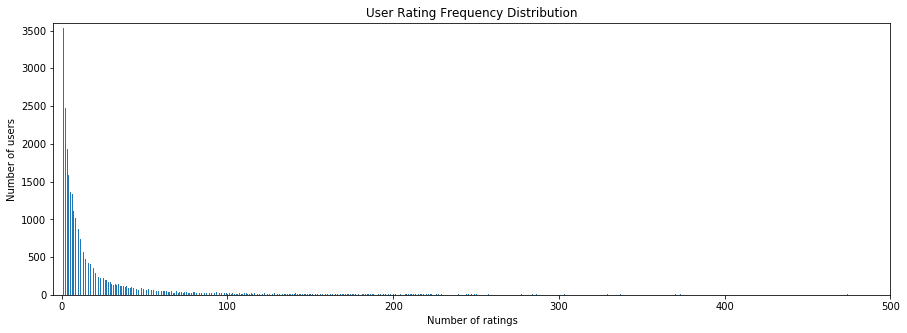

In [22]:
#Exercise 2.1 b)
plt.figure(figsize=(15,5))
plt.bar(totRatingsPerUserArray, numOfUsersArray, width=0.5, align='edge')
plt.axis([-5, 500, 0, 3600])
plt.xlabel("Number of ratings")
plt.ylabel("Number of users")
plt.title("User Rating Frequency Distribution")
plt.show()

## Exercise 2.1 (Advanced analysis)

c) Examining the papers popularity by looking at the number or ratings each paper gets. Calculating and plotting the (number of items, number of ratings) rank-frequency distribution.

In [6]:
#Exercise 2.1 c)
paperRatingInfoDF = userLibDF.select("paper")\
                                .groupBy("paper")\
                                .agg(func.count("paper").alias("num_ratings_per_paper"))\
                                .groupBy("num_ratings_per_paper")\
                                .agg(func.count("num_ratings_per_paper").alias("num_of_papers"))

paperRatingInfoRDD = paperRatingInfoDF.rdd.map(lambda row: (row.num_ratings_per_paper, row.num_of_papers))
totRatingsPerPaperArray = paperRatingInfoRDD.map(lambda row: row[0]).collect()
numOfPapersArray = paperRatingInfoRDD.map(lambda row: row[1]).collect()

paperRatingInfoDF.show(10, truncate=True)

+---------------------+-------------+
|num_ratings_per_paper|num_of_papers|
+---------------------+-------------+
|                    1|          434|
+---------------------+-------------+



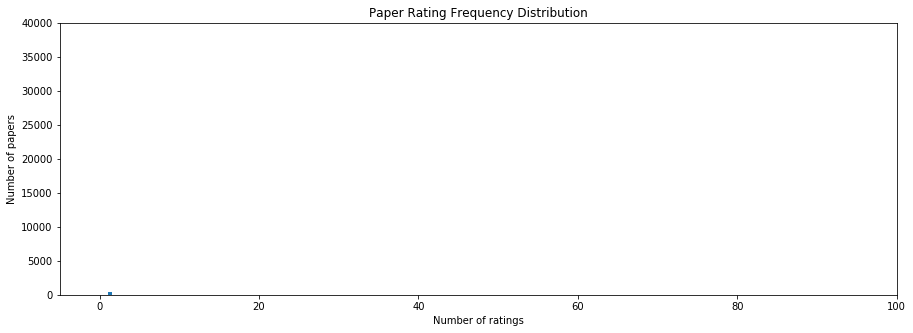

In [7]:
#Exercise 2.1 c)
plt.figure(figsize=(15,5))
plt.bar(totRatingsPerPaperArray, numOfPapersArray, width=0.5, align='edge')
plt.axis([-5, 100, 0, 40000])
plt.xlabel("Number of ratings")
plt.ylabel("Number of papers")
plt.title("Paper Rating Frequency Distribution")
plt.show()

From the (number of items, number of ratings) rank frequency distribution, we observe that it forms a power law with a long tail distribution.

## Exercise 2.2 (Rating matrix preparation)

Building the ratings matrix as a Dataframe with the following columns:<br>
1) user_id: a unique positive integer ID for each user.<br>
2) paper_id: a unique positive integer ID for each item.<br>
3) rating: a number (0 or 1) that represents the ratings given by the user to the item.<br>

In [8]:
#Exercise 2.2
#Generate a unique integer ID for the user hash values.
mapIDToUserHashDF = userLibDF.select("user")\
                                .distinct()\
                                .withColumn("user_id", func.monotonically_increasing_id())

userWinSpec = Window.orderBy("user_id")

mapIDToUserHashDF = mapIDToUserHashDF.withColumn("user_id",\
                                                 func.row_number().over(userWinSpec))
mapIDToUserHashDF.show(10, truncate=True)

+--------------------+-------+
|                user|user_id|
+--------------------+-------+
|ca4f1ba4094011d9a...|      1|
|9c883d02115400f7b...|      2|
|f2f77383828ea6d39...|      3|
|d0c9aaa788153daea...|      4|
|d1d41a15201915503...|      5|
|1eac022a97d683eac...|      6|
+--------------------+-------+



In [9]:
#Exercise 2.2
#Generate a unique integer ID for the papers.
mapIDToPaperDF = userLibDF.select("paper")\
                            .distinct()\
                            .withColumn("paper_id", func.monotonically_increasing_id())

paperWinSpec = Window.orderBy("paper_id")

mapIDToPaperDF = mapIDToPaperDF.withColumn("paper_id",\
                                           func.row_number().over(paperWinSpec))
mapIDToPaperDF.show(10, truncate=True)

+-------+--------+
|  paper|paper_id|
+-------+--------+
|2180593|       1|
|7364971|       2|
|7756088|       3|
|7812276|       4|
| 322433|       5|
|6627520|       6|
|3106933|       7|
|1042553|       8|
|1457751|       9|
|1095192|      10|
+-------+--------+
only showing top 10 rows



In [10]:
#Exercise 2.2
#Mapping the the generated user ID to its respective paper ID.
mapUseIDtoPaperIDDF = mapIDToUserHashDF.join(userLibDF, "user", "inner")\
                                            .join(mapIDToPaperDF, "paper", "inner")\
                                            .select("user_id", "paper_id")
mapUseIDtoPaperIDDF.show(20, truncate=True)

+-------+--------+
|user_id|paper_id|
+-------+--------+
|      6|       1|
|      5|       2|
|      4|       3|
|      6|       4|
|      6|       5|
|      6|       6|
|      6|       7|
|      6|       8|
|      6|      10|
|      6|       9|
|      6|      12|
|      6|      11|
|      6|      14|
|      6|      16|
|      6|      15|
|      6|      18|
|      6|      13|
|      6|      17|
|      6|      21|
|      5|      19|
+-------+--------+
only showing top 20 rows



In [11]:
#Exercise 2.2
#Creating a dataframe that has a list of all the paper IDs rated by each user.
paperListPerUserDF = mapUseIDtoPaperIDDF.groupBy("user_id")\
                                         .agg(func.collect_list("paper_id").alias("paper_id_list"))

paperListPerUserDF.show(10, truncate=True)

+-------+--------------------+
|user_id|       paper_id_list|
+-------+--------------------+
|      1|               [362]|
|      6|[1, 4, 5, 6, 7, 8...|
|      3|     [109, 140, 143]|
|      5|[2, 19, 22, 29, 5...|
|      4|[3, 28, 38, 52, 5...|
|      2|[46, 175, 209, 21...|
+-------+--------------------+



In [12]:
#Exercise 2.2
#Function getList returns a list of unrated paper IDS for a specific user.
#The number of paper IDs in the output list is determined by the number of papers that the user has rated.
def getList(ratedPaperList, paperCount):
    
    #Generate a list of paper IDs between 1 and the max paper ID.
    genPaperList = list(range(1, paperCount+1))
    
    #randomly shuffle the list of broadcast values.
    ran.shuffle(genPaperList)

    ratedPaperSet = set(ratedPaperList)
    #generating a list of unrated paper list.
    unratedPaperList = [paperID for paperID in genPaperList if paperID not in ratedPaperSet]
    
    #Get the lengths of the rated and unrated lists.
    unratedListLength = len(unratedPaperList)
    ratedListLength = len(ratedPaperList)
    
    #if length of unrated list is less than the rated list.
    if unratedListLength < ratedListLength:
        #return the whole unrated papers lists.
        return unratedPaperList[0:unratedListLength]
    else:
        #else return a list of same length as the rated papers list.
        return unratedPaperList[0:ratedListLength]
    
#Creating a user defined function
udf_getList = udf(getList, ArrayType(StringType()))

In [13]:
#Exercise 2.2
#Count the number of unique papers
uniqPaperCount = userLibDF.select(userLibDF.paper).distinct().count()
uniqPaperCount

434

In [14]:
#Exercise 2.2

#Creating a dataframe containing both list of rated and unrated papers.
ratedAndUnratedDF = paperListPerUserDF.select(paperListPerUserDF.user_id,\
                                              paperListPerUserDF.paper_id_list,\
                                              func.lit(udf_getList(paperListPerUserDF.paper_id_list,\
                                                                   func.lit(uniqPaperCount)\
                                                                  )).alias("unrated_paper_id_list"))

ratedAndUnratedDF.show(10, truncate=True)

+-------+--------------------+---------------------+
|user_id|       paper_id_list|unrated_paper_id_list|
+-------+--------------------+---------------------+
|      1|               [362]|                [413]|
|      6|[1, 4, 5, 6, 7, 8...| [209, 233, 236, 2...|
|      3|     [109, 140, 143]|      [369, 275, 327]|
|      5|[2, 19, 22, 29, 5...| [433, 427, 302, 8...|
|      4|[3, 28, 38, 52, 5...| [372, 194, 25, 54...|
|      2|[46, 175, 209, 21...| [183, 241, 231, 2...|
+-------+--------------------+---------------------+



In [15]:
#Exercise 2.2
#Adding a rating value of "1" to the rated papers.
explodedRatedPaperDF = mapUseIDtoPaperIDDF.withColumn("rating", func.lit(1))
explodedRatedPaperDF.show(10, truncate=True)

+-------+--------+------+
|user_id|paper_id|rating|
+-------+--------+------+
|      6|       1|     1|
|      5|       2|     1|
|      4|       3|     1|
|      6|       4|     1|
|      6|       5|     1|
|      6|       6|     1|
|      6|       7|     1|
|      6|       8|     1|
|      6|      10|     1|
|      6|       9|     1|
+-------+--------+------+
only showing top 10 rows



In [16]:
#Exercise 2.2
#Exploding the dataframe to get a row for each paper id in the unrated_paper_id_list.
#Adding a rating value of "0" to the unrated papers
explodedUnratedPaperDF = ratedAndUnratedDF.select("user_id",\
                                        "unrated_paper_id_list")\
                                    .withColumn("paper_id",\
                                               func.explode(ratedAndUnratedDF.unrated_paper_id_list))\
                                    .drop("unrated_paper_id_list")\
                                    .withColumn("rating", func.lit(0))
explodedUnratedPaperDF.show(10, truncate=True)

+-------+--------+------+
|user_id|paper_id|rating|
+-------+--------+------+
|      1|     212|     0|
|      6|     292|     0|
|      6|     190|     0|
|      6|     130|     0|
|      6|      87|     0|
|      6|     150|     0|
|      6|     140|     0|
|      6|      53|     0|
|      6|      28|     0|
|      6|     243|     0|
+-------+--------+------+
only showing top 10 rows



In [17]:
#Exercise 2.2
#Creating the rating matrix by the union of rated papers and unrated papers dataframes.
tempRatingMatrixDF = explodedRatedPaperDF.union(explodedUnratedPaperDF)

ratingMatrixDF = tempRatingMatrixDF.withColumn("paper_id", tempRatingMatrixDF.paper_id.cast(IntegerType()))
#ratingMatrixDF.orderBy("user_id", "paper_id").show(20, truncate=True)
ratingMatrixDF.show(20, truncate=True)

+-------+--------+------+
|user_id|paper_id|rating|
+-------+--------+------+
|      6|       1|     1|
|      5|       2|     1|
|      4|       3|     1|
|      6|       4|     1|
|      6|       5|     1|
|      6|       6|     1|
|      6|       7|     1|
|      6|       8|     1|
|      6|      10|     1|
|      6|       9|     1|
|      6|      12|     1|
|      6|      11|     1|
|      6|      14|     1|
|      6|      16|     1|
|      6|      15|     1|
|      6|      18|     1|
|      6|      13|     1|
|      6|      17|     1|
|      6|      21|     1|
|      5|      19|     1|
+-------+--------+------+
only showing top 20 rows



## Exercise 2.3 (ALS algorithm)
Program that employs ALS to fit a model for the user-paper ratings matrix.<br>
The learned model is used to generate top 10 recommendations for all users using the recommendForAllUsers method.<br>
Outputting the top 10 recommendations for user with user_hash_id = 1eac022a97d683eace8815545ce3153f.

In [18]:
#Exercise 2.3
#Build the recommendation model using ALS on the user-paper dataset.
als = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", coldStartStrategy="drop")
#Fit a model to the input dataset.
model = als.fit(ratingMatrixDF)


In [19]:
#Exercise 2.3
#Get the top 10 papers recommended for each user, for all users.
top10UserRecommendations = model.recommendForAllUsers(10)
top10UserRecommendations.show(10, truncate=True)


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[[362, 0.80000377...|
|      6|[[160, 0.8939501]...|
|      3|[[140, 0.7999948]...|
|      5|[[53, 0.80226904]...|
|      4|[[162, 0.8031663]...|
|      2|[[219, 0.8078058]...|
+-------+--------------------+



In [20]:
#Exercise 2.3
#Displaying the papers recommended for all users.
tempAllUserRecDF = top10UserRecommendations.select("user_id",\
                                                   func.explode(top10UserRecommendations.recommendations)\
                                                   .alias("recommendation"))\
                                            .join(mapIDToUserHashDF, "user_id", "inner")

allUserRecDF = tempAllUserRecDF.select("user_id","user","recommendation.*")\
                                .join(mapIDToPaperDF,"paper_id","inner")\
                                .select("user_id", "user", "paper_id", "paper", "rating")\
                                .orderBy("user_id", "paper_id")
allUserRecDF.show()

+-------+--------------------+--------+-------+----------+
|user_id|                user|paper_id|  paper|    rating|
+-------+--------------------+--------+-------+----------+
|      1|ca4f1ba4094011d9a...|       2|7364971|0.21315815|
|      1|ca4f1ba4094011d9a...|      53|6609238|0.21315815|
|      1|ca4f1ba4094011d9a...|      92|6610585|0.21315815|
|      1|ca4f1ba4094011d9a...|     101|7469738|0.21315815|
|      1|ca4f1ba4094011d9a...|     111|6609222|0.21315815|
|      1|ca4f1ba4094011d9a...|     130|7499869|0.21315815|
|      1|ca4f1ba4094011d9a...|     150|7427963|0.21315815|
|      1|ca4f1ba4094011d9a...|     191|7364933|0.21315815|
|      1|ca4f1ba4094011d9a...|     262|3105791|0.21315815|
|      1|ca4f1ba4094011d9a...|     362| 278019|0.80000377|
|      2|9c883d02115400f7b...|      46|3878624|0.73697567|
|      2|9c883d02115400f7b...|     175|4174633| 0.8078058|
|      2|9c883d02115400f7b...|     190|5687747|0.35272288|
|      2|9c883d02115400f7b...|     209|3365220| 0.807805

In [21]:
#Exercise 2.3
#Getting the user_id of the specific user with user hash = 1eac022a97d683eace8815545ce3153f.
specUserId = mapIDToUserHashDF.filter(mapIDToUserHashDF.user=="1eac022a97d683eace8815545ce3153f").select("user_id")

#Get the top 10 papers recommended for the user (user hash = 1eac022a97d683eace8815545ce3153f).
rawSpecUserRecDF = model.recommendForUserSubset(specUserId, 10)
rawSpecUserRecDF.show(10, truncate=True)


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      6|[[160, 0.8939501]...|
+-------+--------------------+



In [22]:
#Exercise 2.3
#Displaying the papers recommended for user with user hash value = 1eac022a97d683eace8815545ce3153f.
tempSpecUserRecDF = rawSpecUserRecDF.join(mapIDToUserHashDF,"user_id","inner")\
                                    .select("user_id",\
                                            mapIDToUserHashDF.user,\
                                            func.explode(rawSpecUserRecDF.recommendations)\
                                            .alias("recommendation"))

specUserDF = tempSpecUserRecDF.select("user_id","user","recommendation.*")\
                            .join(mapIDToPaperDF,"paper_id","inner")\
                            .select("user_id", "user", "paper_id", "paper", "rating")\
                            .orderBy("paper_id")

specUserDF.show()


+-------+--------------------+--------+--------+---------+
|user_id|                user|paper_id|   paper|   rating|
+-------+--------------------+--------+--------+---------+
|      6|1eac022a97d683eac...|      10| 1095192|0.8939501|
|      6|1eac022a97d683eac...|      20|  854207|0.8939501|
|      6|1eac022a97d683eac...|      30| 9730873|0.8939501|
|      6|1eac022a97d683eac...|      40|  423382|0.8939501|
|      6|1eac022a97d683eac...|      50| 2999253|0.8939501|
|      6|1eac022a97d683eac...|      70| 3332739|0.8939501|
|      6|1eac022a97d683eac...|     100|14120961|0.8939501|
|      6|1eac022a97d683eac...|     110| 5127341|0.8939501|
|      6|1eac022a97d683eac...|     160| 6452999|0.8939501|
|      6|1eac022a97d683eac...|     200| 6819940|0.8939501|
+-------+--------------------+--------+--------+---------+



## Exercise 2.4 (Recommender System Evaluation)
Using Spark to evaluate ALS-based recommender built in previous exercise.<br>
a) Split the ratings randomly into training set and test set with 70% and 30% of the dataset.<br>
b) Fit a model on the training set.<br>
c) Calculate the Root Mean Squared Error (RMSE) over the test set.<br>
d) Generate top 10 recommendations over the test set:<br>
&emsp;&emsp;1) Apply the learned model over the test set.<br>
&emsp;&emsp;2) For each user, order the papers by the predicted ratings descendingly.<br>
&emsp;&emsp;3) Choose the top 10 papers to be the recommendations for that user.<br>

In [23]:
#Exercise 2.4
#Randomly splitting the ratings matrix into training and test sets with 0.7 and 0.3 as weights.
(trainingDF, testDF) = ratingMatrixDF.randomSplit([0.7, 0.3])

#Building the recommendation model using ALS.
alsEval = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", coldStartStrategy="drop")
#Fitting a model to the input dataset.
modelEval = alsEval.fit(trainingDF)

#Transforming the test dataset over the trained model.
predictionsDF = modelEval.transform(testDF)
#Evaluation of the model by calculating the RMSE on the test dataset.
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictionsDF)
print("Root Mean Square Error of the test data = " ,str(rmse))

Root Mean Square Error of the test data =  0.7171394728798212


In [24]:
#Exercise 2.4
#For each user, order the papers by the predicted ratings descendingly.
predictWindow = Window.partitionBy("user_id").orderBy(func.desc("prediction"))

#Adding a rank to the papers according to their prediction value.
rankedPredictionDF = predictionsDF.withColumn("ranking", func.row_number().over(predictWindow))

#Top 10 papers with highest prediction value for each user.
top10rankedPredictionDF = rankedPredictionDF.filter(rankedPredictionDF.ranking<=10)
top10rankedPredictionDF.show(20, truncate=True)

+-------+--------+------+------------+-------+
|user_id|paper_id|rating|  prediction|ranking|
+-------+--------+------+------------+-------+
|      1|     124|     0|-0.061106466|      1|
|      6|     101|     0|0.0015270896|      1|
|      6|     218|     0|0.0015270896|      2|
|      6|     266|     0|0.0015270896|      3|
|      6|     267|     0|0.0015270896|      4|
|      6|     245|     0|0.0015270896|      5|
|      6|     237|     0|0.0015270896|      6|
|      6|     426|     0|0.0015270896|      7|
|      6|      99|     0|0.0015270896|      8|
|      6|     166|     0|0.0013662707|      9|
|      6|     368|     0|0.0012171976|     10|
|      3|     143|     1|         0.0|      1|
|      5|     126|     0|9.4429404E-4|      1|
|      5|     404|     0|9.4429404E-4|      2|
|      5|      95|     0| 8.567739E-4|      3|
|      5|     414|     0| 8.567739E-4|      4|
|      5|      53|     1|         0.0|      5|
|      5|     255|     1|         0.0|      6|
|      5|    

In [25]:
#Exercise 2.4
#retrieving the paper and user
top10rankedPredictionDF.join(mapIDToUserHashDF,"user_id","inner")\
                        .join(mapIDToPaperDF,"paper_id","inner")\
                        .orderBy(["user_id", "ranking"], ascending=[1, 1])\
                        .select("user_id", "user", "paper_id", "paper", "prediction", "ranking").show()

+-------+--------------------+--------+--------+-------------+-------+
|user_id|                user|paper_id|   paper|   prediction|ranking|
+-------+--------------------+--------+--------+-------------+-------+
|      1|ca4f1ba4094011d9a...|     246| 7329626|          0.0|      1|
|      2|9c883d02115400f7b...|     122| 8277825|  -0.00505933|      1|
|      3|f2f77383828ea6d39...|     143|  763429|          0.0|      1|
|      3|f2f77383828ea6d39...|     158| 3206364|-0.0024050996|      2|
|      4|d0c9aaa788153daea...|     211|  854459| 8.5030403E-4|      1|
|      4|d0c9aaa788153daea...|     384| 2500019| 8.5030403E-4|      2|
|      4|d0c9aaa788153daea...|      51|12335203| 8.5030403E-4|      3|
|      4|d0c9aaa788153daea...|      83| 5777260| 8.5030403E-4|      4|
|      4|d0c9aaa788153daea...|     363| 8020025|  7.735491E-4|      5|
|      4|d0c9aaa788153daea...|     321| 5336762|          0.0|      6|
|      4|d0c9aaa788153daea...|      28| 3140015|          0.0|      7|
|     

## Exercise 2.5
2 of ALS parameters are:<br>
&emsp;&emsp;a) rank - is the number of latent factors in the model (defaults to 10)<br>
&emsp;&emsp;b) maxIter - is the maximum number of iterations to run (defaults to 10)<br>

In [26]:
#Exercise 2.5
#Building the recommendation model using ALS.
alsRank = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", coldStartStrategy="drop")
#Build ParamGridBuilder to construct a grid of parameters to search over.
paramRank = ParamGridBuilder().addGrid(alsRank.rank, [10, 25, 50]).build()

#Create an instance of CrossValidator.
crossValidatorRank = CrossValidator(estimator=alsRank,\
                                    estimatorParamMaps=paramRank,\
                                    evaluator=evaluator,\
                                    numFolds=2)
#Create a CrossValidator model and fit with the rating matrix.
CVRankModel = crossValidatorRank.fit(ratingMatrixDF)


In [27]:
#Exercise 2.5
#Optimal value for Rank that optimises RMSE
CVRankModel.bestModel.rank

10

In [28]:
#Exercise 2.5
#RMSE value obtained with the optimal value for Rank
CVRankModel.avgMetrics[1]

[0.6473353211745434, 0.6476330915907835, 0.6473521717288513]

In [30]:
#Building the recommendation model using ALS.
alsMaxIter = ALS(userCol="user_id", itemCol="paper_id", ratingCol="rating", coldStartStrategy="drop")
#Build ParamGridBuilder to construct a grid of parameters to search over.
paramMaxIter = ParamGridBuilder().addGrid(alsRank.maxIter, [5, 10, 15, 20, 25]).build()

#Create an instance of CrossValidator.
crossValidatorMaxIter = CrossValidator(estimator=alsMaxIter,\
                                       estimatorParamMaps=paramMaxIter,\
                                       evaluator=evaluator,\
                                       numFolds=2)
#Create a CrossValidator model and fit with the rating matrix.
CVMaxIterModel = crossValidatorMaxIter.fit(ratingMatrixDF)

In [32]:
#Plotting maxIter parameters values against the RMSE
plt.plot([5, 10, 15, 20, 25],CVMaxIterModel.avgMetrics)
plt.ylabel("Root Mean Square Error")
plt.xlabel("Max Iteration values")
plt.show()

[0.6493863684688838,
 0.6493863684688838,
 0.6493863684688838,
 0.6493863684688838,
 0.6493863684688838]